# CDS Credit risk

In [10]:
# ============================================================
# CELL 1 — Imports & configuration de base
# Objectif : charger les librairies, définir les chemins/paramètres,
#            créer un dossier pour sauvegarder les sorties.
# ============================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.optimize import curve_fit
from scipy import stats
from scipy.special import erfinv

# (optionnel) style de graphiques
sns.set(style="whitegrid")

# --- CONFIG UTILISATEUR ---
MAP_PATH = "data/XDS_Id_Mapping.csv"  # mapping Nom ↔ CDS_Id
CDS_PATH = "data/ITRAXX5Y.csv"        # séries CDS 5Y (Y05)
SELECTED_NAMES = ["Barclays", "Societe Generale", "Unicredito Italiano"]  # noms à illustrer
POST_START = pd.Timestamp("2008-01-01")        # on élimine les dates avant
BINS = 50                                      # nb de bacs pour l'ajustement histogramme
OOT_FRACTION = 0.20                             # dernière fraction en "out-of-time" (test)
OOT_START = None                                # alternative : date de split (ex: pd.Timestamp("2013-01-01"))
SAVE_DIR = "output"                             # où écrire CSV/PNG
os.makedirs(SAVE_DIR, exist_ok=True)


In [11]:
# ============================================================
# CELL 2 — Chargement & nettoyage des données
# Objectif : lire les CSV, parser les dates, forcer Y05 en numérique,
#            trier et retirer les valeurs manquantes.
# ============================================================
df_map = pd.read_csv(MAP_PATH, sep=";", engine="python")

df_cds = pd.read_csv(
    CDS_PATH,
    sep=";", engine="python",
    parse_dates=["Date"], dayfirst=True
)
df_cds["Y05"] = pd.to_numeric(df_cds["Y05"], errors="coerce")
df_cds = df_cds.dropna(subset=["Date", "Y05"]).sort_values("Date")

print(f"[INFO] mapping: {df_map.shape}, cds: {df_cds.shape}")


[INFO] mapping: (225, 2), cds: (995145, 4)


In [12]:
# ============================================================
# CELL 3 — Dictionnaire Nom → liste de CDS_Id
# Objectif : construire une table de correspondance pour retrouver
#            rapidement les CDS_Id d’un émetteur.
# ============================================================
dc_map = defaultdict(list)
for _, row in df_map.iterrows():
    dc_map[row["Name"]].append(row["CDS_Id"])

# aperçu rapide
print("[INFO] exemples mapping:", {k: dc_map[k][:3] for k in list(dc_map)[:5]})


[INFO] exemples mapping: {'Total': [261], 'Saint-Gobain': [238], 'Barclays': [570, 2906], 'ING Bank': [2894, 135], 'Publicis Groupe': [192]}


In [13]:
# ============================================================
# CELL 4 — Séries par CDS_Id & calcul des rendements quotidiens
# Objectif : pour chaque CDS_Id, obtenir la série Y05 indexée par date
#            puis calculer le pct_change (retour journalier).
#            On filtre les dates avant POST_START.
# ============================================================
# séries par id
by_id = {
    cid: g.set_index("Date")["Y05"].sort_index()
    for cid, g in df_cds.groupby("CDS_Id", sort=False)
}

# rendements journaliers
dc_returns = {}
for cid, s in by_id.items():
    s = s.groupby(s.index).last().sort_index()
    s = s[s.index >= POST_START]
    dc_returns[cid] = s.pct_change().rename(cid)

# comptage des séries non vides
non_empty = sum(ser.dropna().shape[0] > 0 for ser in dc_returns.values())
print(f"[INFO] séries de rendements non vides: {non_empty}/{len(dc_returns)}")


[INFO] séries de rendements non vides: 225/225


In [15]:
# ============================================================
# CELL 5 — Gaussianisation empirique (non paramétrique)
# Objectif : transformer chaque série en ~N(0,1) via les rangs :
#            u = (rang-0.5)/N ; z = Φ^{-1}(u)
# Avantage : pas d’hypothèse de loi, robuste aux queues épaisses.
# ============================================================
def gaussianize_empirical(ser: pd.Series) -> pd.Series:
    s = pd.Series(ser).replace([np.inf, -np.inf], np.nan).dropna()
    if s.empty:
        return s
    ranks = s.rank(method="average")                 # 1..N
    u = (ranks - 0.5) / len(s)                       # (0,1)
    z = np.sqrt(2.0) * erfinv(2.0*u - 1.0)           # Φ^{-1}(u)
    return pd.Series(z, index=s.index, name=ser.name)

dc_gauss_emp = {cid: gaussianize_empirical(ser) for cid, ser in dc_returns.items()}
print("[INFO] gaussianisation empirique effectuée.")


[INFO] gaussianisation empirique effectuée.


In [14]:
# ============================================================
# CELL 6 — Définition de la loi SMW & outils d’ajustement
# Objectif : 1) définir la densité Symmetric Modified Weibull (SMW),
#            2) fonction pour ajuster (c, chi) sur histogramme,
#            3) transformation fermée SMW → Normal.
# ============================================================
def smw_pdf(x, c, chi):
    """
    Densité SMW symétrique :
    f(x) = c / (2 sqrt(pi) chi^{c/2}) * |x|^{c/2 - 1} * exp( - (|x|/chi)^c )
    """
    x = np.asarray(x, dtype=float)
    x_abs = np.maximum(np.abs(x), 1e-12)  # évite singularité à 0
    coef  = c / (2.0 * np.sqrt(np.pi) * (chi ** (c / 2.0)))
    return coef * (x_abs ** (c / 2.0 - 1.0)) * np.exp(- (x_abs / chi) ** c)

def fit_smw_hist(s: pd.Series, bins=BINS):
    """
    Ajuste (c, chi) en moindres carrés sur la densité histogramme (robuste/simple).
    Renvoie (c_hat, chi_hat) ou None si échec.
    """
    s = pd.Series(s).replace([np.inf, -np.inf], np.nan).dropna()
    if s.empty:
        return None
    y, edges = np.histogram(s.values, bins=bins, density=True)
    x = 0.5 * (edges[:-1] + edges[1:])
    if len(x) == 0 or np.all(y == 0):
        return None

    # bons points de départ
    c0 = 1.5
    chi0 = np.median(np.abs(s.values))
    if not np.isfinite(chi0) or chi0 <= 0:
        chi0 = np.std(s.values)
    if not np.isfinite(chi0) or chi0 <= 0:
        return None

    # bornes (c>0 ; chi>0)
    chi_ub = max(1.0, 10.0 * np.std(np.abs(s.values)))
    bounds = ((0.2, 1e-6), (10.0, chi_ub))

    try:
        (c_hat, chi_hat), _ = curve_fit(
            smw_pdf, x, y, p0=(c0, chi0), bounds=bounds, maxfev=20000
        )
        return float(c_hat), float(chi_hat)
    except Exception:
        return None

def smw_gauss_transform(s: pd.Series, c: float, chi: float) -> pd.Series:
    """
    Transformation SMW → Normal : z = sign(x) * sqrt(2) * (|x|/chi)^(c/2)
    (si X ~ SMW(c,chi), alors Z ~ N(0,1))
    """
    s = pd.Series(s).replace([np.inf, -np.inf], np.nan)
    return np.sign(s) * np.sqrt(2.0) * np.power(np.abs(s) / chi, c / 2.0)


In [16]:
# ============================================================
# CELL 7 — Split train / out-of-time (OOT) & application SMW
# Objectif : séparer chaque série en train et test OOT,
#            ajuster (c,chi) sur apprentissage, transformer OOT,
#            et calculer un diagnostic de normalité (KS).
# ============================================================
def split_train_oot(s: pd.Series, oot_fraction=OOT_FRACTION, oot_start=OOT_START):
    s = pd.Series(s).dropna().sort_index()
    if s.empty:
        return s.iloc[0:0], s.iloc[0:0]
    if oot_start is not None:
        return s[s.index < oot_start], s[s.index >= oot_start]
    if oot_fraction is None:
        oot_fraction = 0.2
    cut = int(np.floor((1 - oot_fraction) * len(s)))
    return s.iloc[:cut], s.iloc[cut:]

smw_params = {}
gauss_train, gauss_oot, diag = {}, {}, {}

for cid, ser in dc_returns.items():
    tr, tt = split_train_oot(ser)
    # garde-fous : on évite les ajustements sur échantillons trop courts
    if len(tr) < 200 or len(tt) < 50:
        continue

    params = fit_smw_hist(tr)
    if params is None:
        continue

    c_hat, chi_hat = params
    smw_params[cid] = (c_hat, chi_hat)

    g_tr = smw_gauss_transform(tr, c_hat, chi_hat).dropna()
    g_tt = smw_gauss_transform(tt, c_hat, chi_hat).dropna()
    gauss_train[cid] = g_tr
    gauss_oot[cid] = g_tt

    # Diagnostic KS sur OOT (après centrage-réduction)
    if len(g_tt) > 20 and (sd := g_tt.std(ddof=1)) and np.isfinite(sd) and sd > 0:
        z = (g_tt - g_tt.mean()) / sd
        ks = stats.kstest(z, 'norm')
        diag[cid] = {
            "c": c_hat, "chi": chi_hat,
            "OOT_mean": float(g_tt.mean()),
            "OOT_std": float(sd),
            "KS_stat": float(ks.statistic),
            "KS_p": float(ks.pvalue),
            "n_train": int(len(tr)),
            "n_oot": int(len(tt)),
        }

print(f"[INFO] SMW ajusté sur {len(smw_params)} IDs ; diagnostics OOT: {len(diag)}")


[INFO] SMW ajusté sur 225 IDs ; diagnostics OOT: 225


In [17]:
# ============================================================
# export CSV  
# Objectif : sauvegarder les séries gaussianisées (empiriques),
#            les paramètres SMW et les diagnostics OOT.
# ============================================================
# large panel (dates x CDS_Id) pour la gaussianisation empirique
emp_wide = pd.DataFrame({k: pd.Series(v) for k, v in dc_gauss_emp.items()})
emp_wide.to_csv(f"{SAVE_DIR}/gaussian_empirical_wide.csv")

if smw_params:
    pd.DataFrame(smw_params, index=["c", "chi"]).T.to_csv(f"{SAVE_DIR}/smw_params_train.csv")

if diag:
    pd.DataFrame(diag).T.to_csv(f"{SAVE_DIR}/smw_oot_diagnostics.csv")

print(f"[INFO] CSV écrits dans: {SAVE_DIR}")


[INFO] CSV écrits dans: output


In [18]:
# ============================================================
# CELL 9 — Fonctions d’affichage (TS, histogrammes, QQ)
# Objectif : utilitaires pour afficher rapidement par émetteur (Nom)
#            en utilisant le mapping Nom → liste de CDS_Id.
# ============================================================
def plot_name_timeseries(name, data_dict, title_suffix, fname_suffix):
    ids = dc_map.get(name, [])
    if not ids:
        print(f"[WARN] Aucun CDS_Id pour '{name}'")
        return
    fig, ax = plt.subplots(figsize=(16, 4))
    plotted = 0
    for cid in ids:
        s = data_dict.get(cid)
        if s is None or s.dropna().empty:
            continue
        s.dropna().plot(ax=ax, label=f"{name} #{cid}", alpha=0.9)
        plotted += 1
    if plotted:
        ax.set_title(f"{name} — {title_suffix}")
        ax.grid(True, alpha=0.3)
        ax.legend(ncol=4)
        plt.tight_layout()
        plt.savefig(f"{SAVE_DIR}/{fname_suffix}_{name}.png", dpi=150)
        plt.show()
    else:
        plt.close(fig)
        print(f"[WARN] Rien à tracer pour '{name}' (données vides).")

def plot_name_distributions(name, data_dict, title_suffix, fname_suffix):
    ids = dc_map.get(name, [])
    if not ids:
        print(f"[WARN] Aucun CDS_Id pour '{name}'")
        return
    n = len(ids)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(16, 3.6*n), sharex=True)
    axes = np.atleast_1d(axes)
    any_vis = False
    for i, cid in enumerate(ids):
        ax = axes[i]
        s = data_dict.get(cid)
        if s is None or s.dropna().empty:
            ax.set_visible(False)
            continue
        any_vis = True
        data = s.dropna()
        sns.histplot(data, ax=ax, stat="density", bins=60, kde=True)
        mu, sd = data.mean(), data.std(ddof=1)
        if sd and np.isfinite(sd):
            xg = np.linspace(mu - 4*sd, mu + 4*sd, 400)
            ax.plot(xg, stats.norm.pdf(xg, loc=mu, scale=sd), lw=1.2, label="Ajustement Normal")
        ax.set_title(f"{name} #{cid} — {title_suffix}")
        ax.grid(True, alpha=0.2)
        ax.legend()
    if any_vis:
        plt.tight_layout()
        plt.savefig(f"{SAVE_DIR}/{fname_suffix}_{name}.png", dpi=150)
        plt.show()
    else:
        plt.close(fig)
        print(f"[WARN] Aucun histogramme pour '{name}'.")


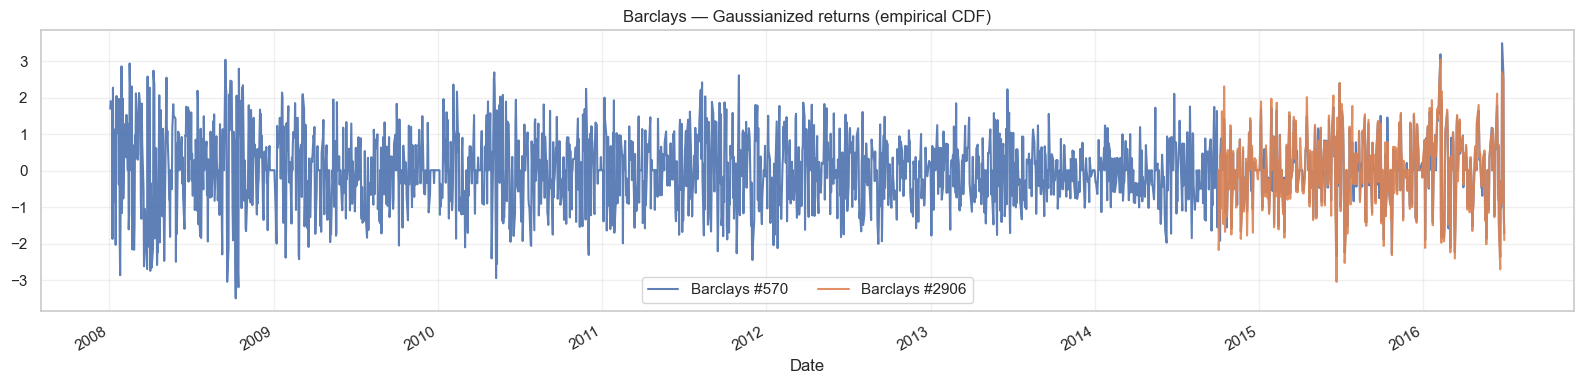

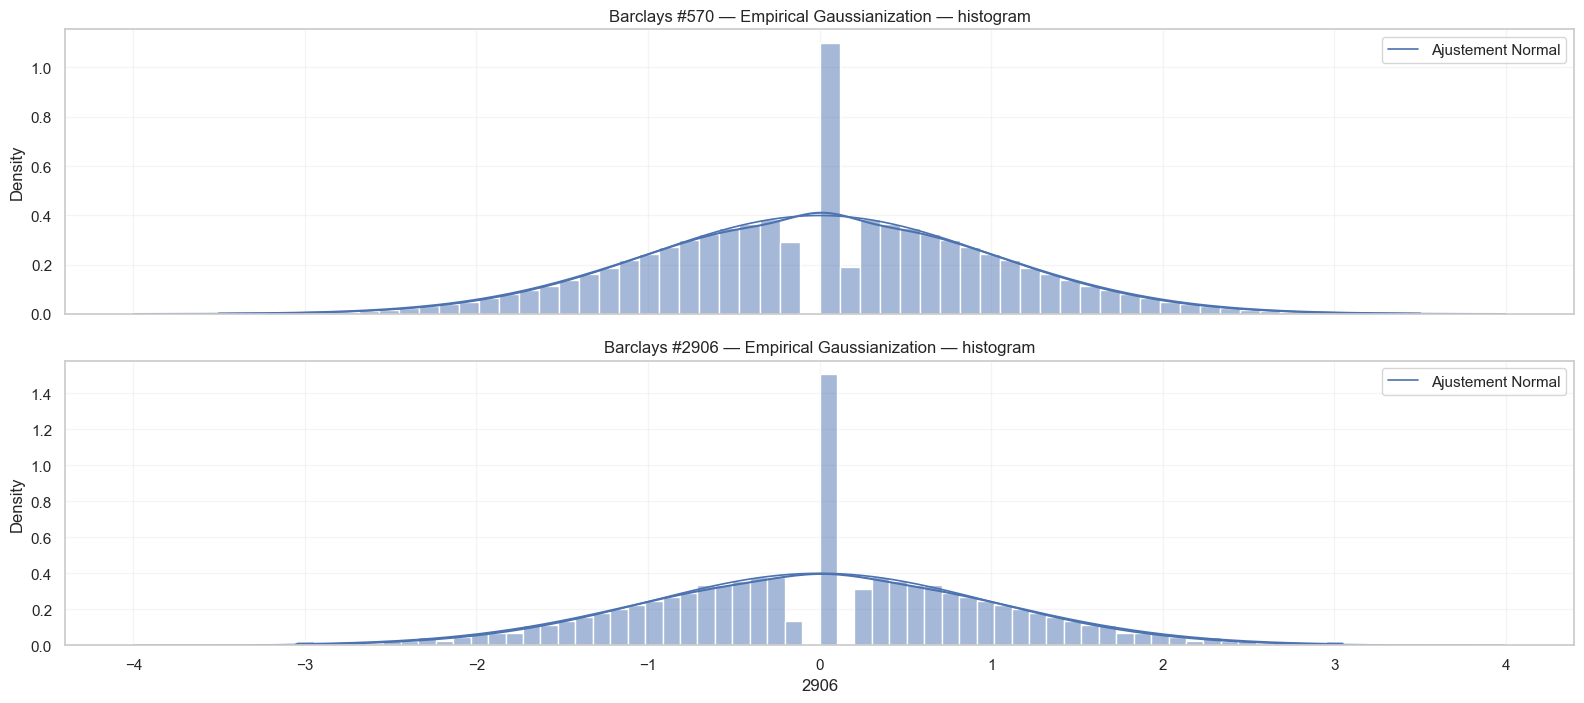

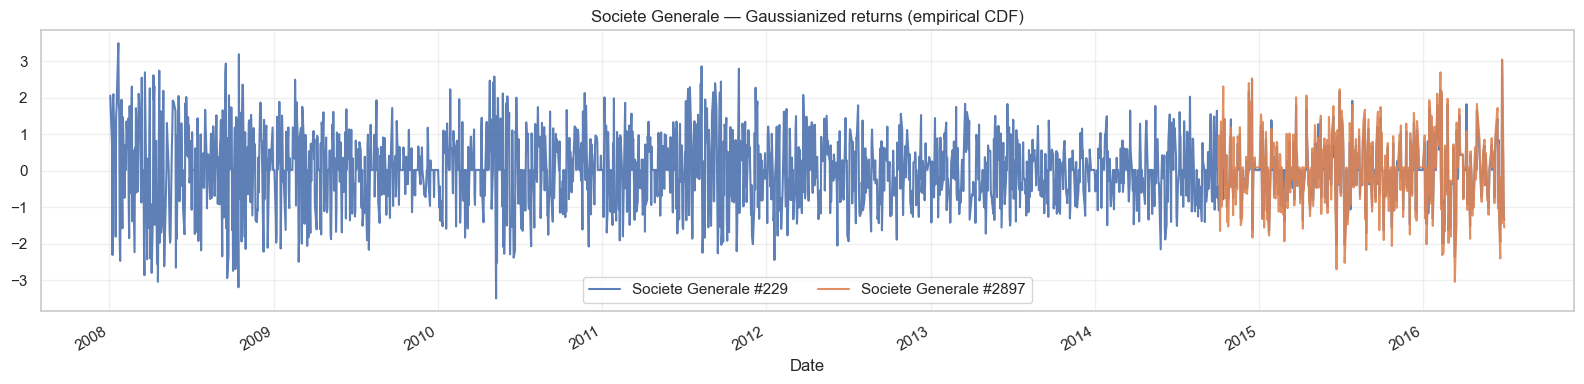

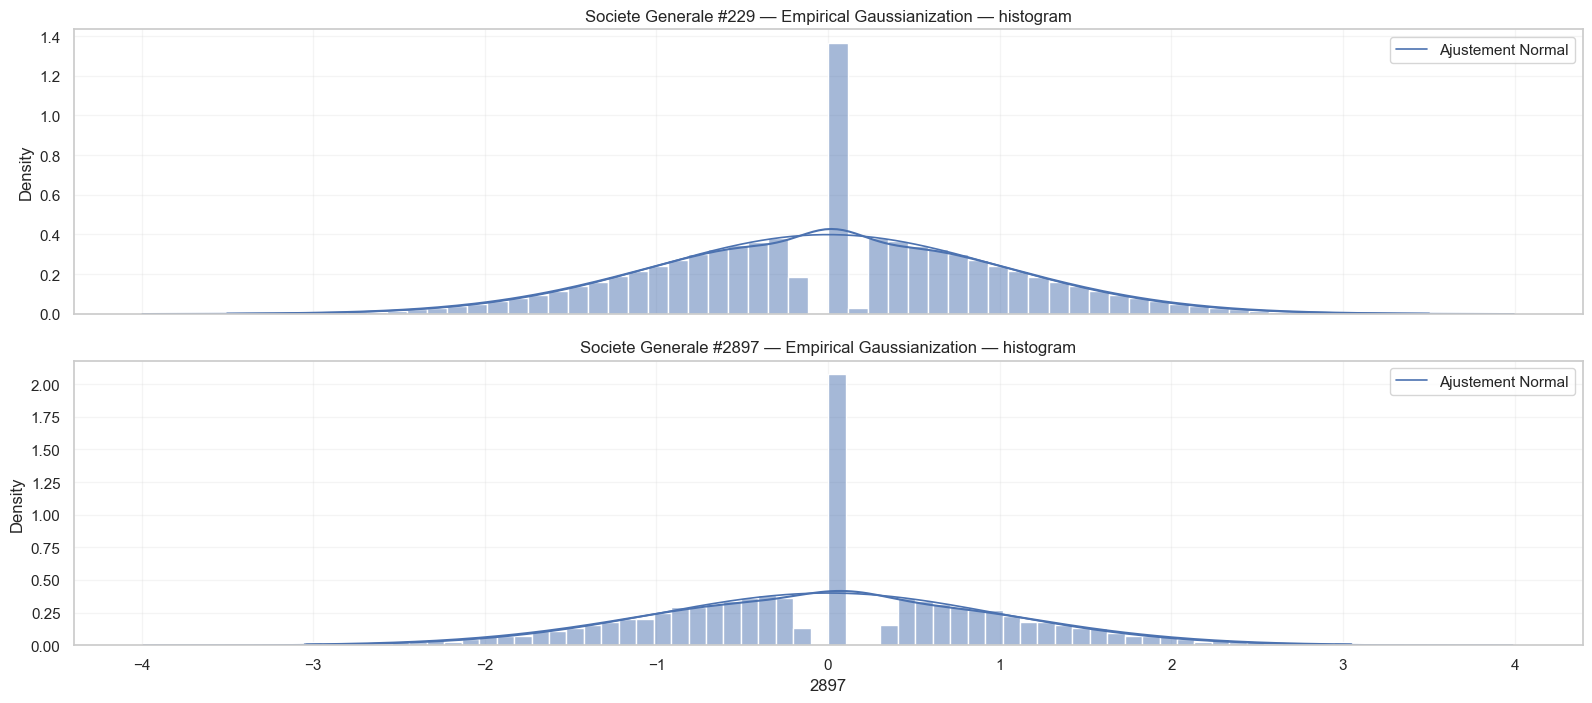

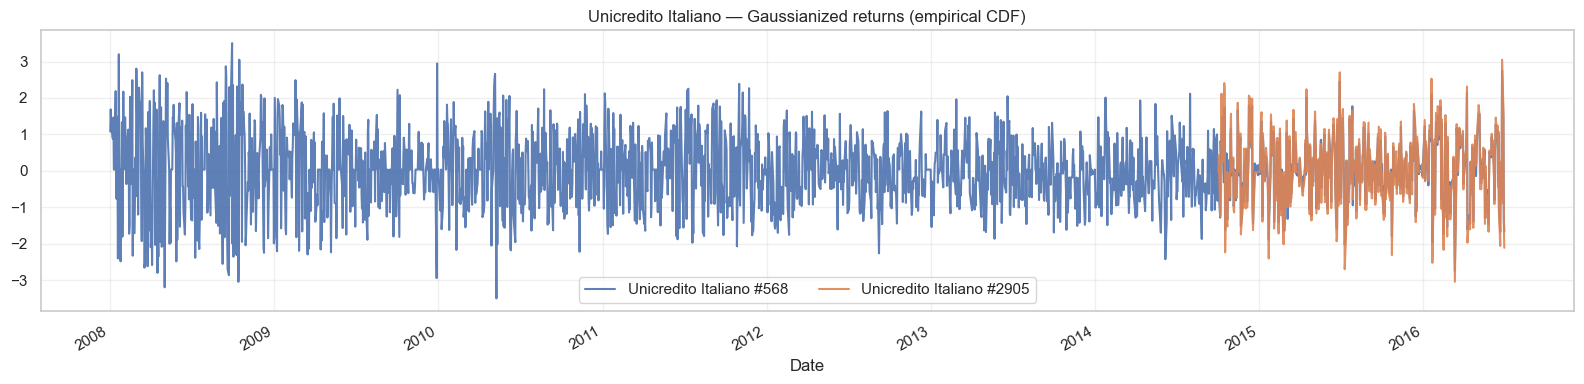

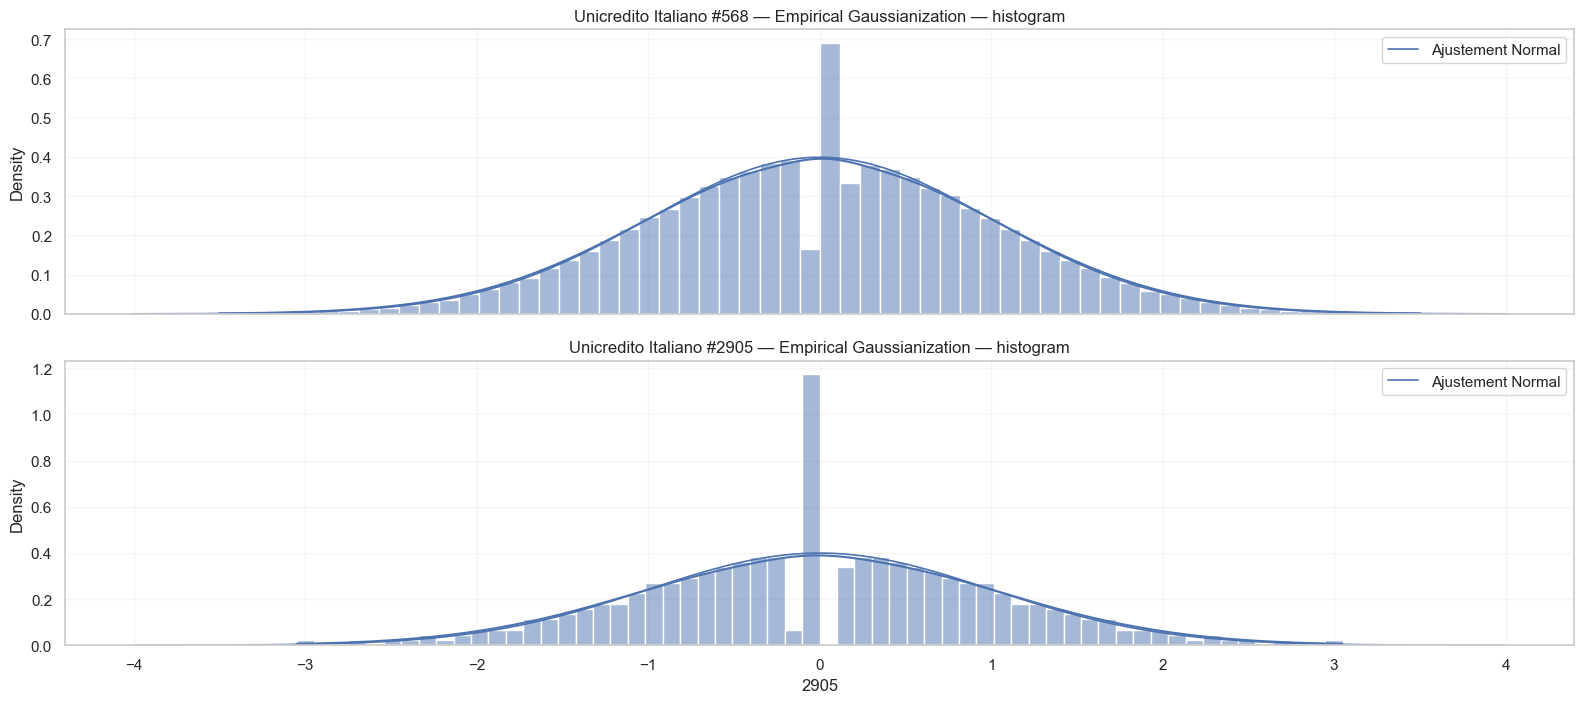

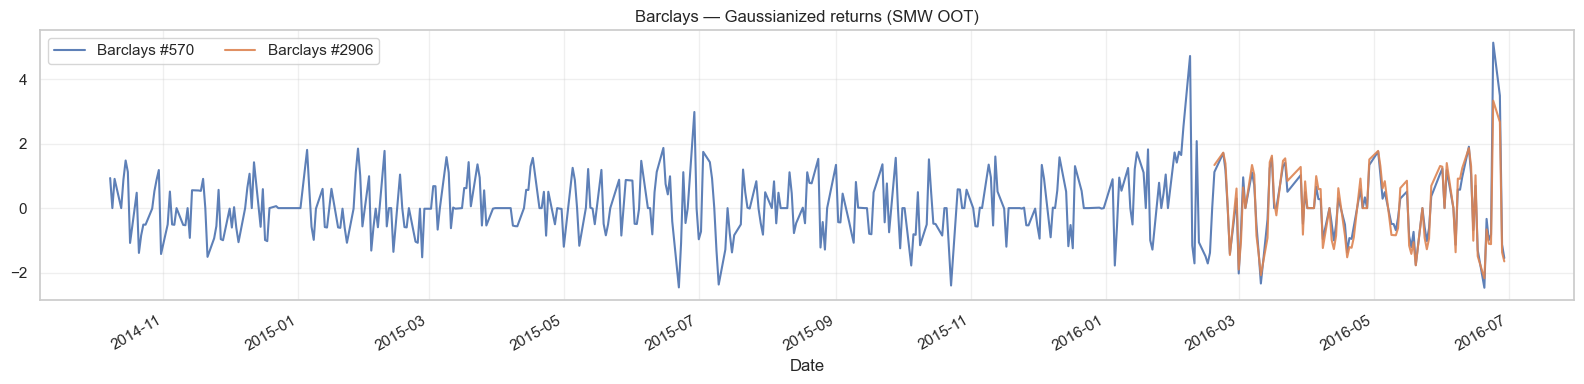

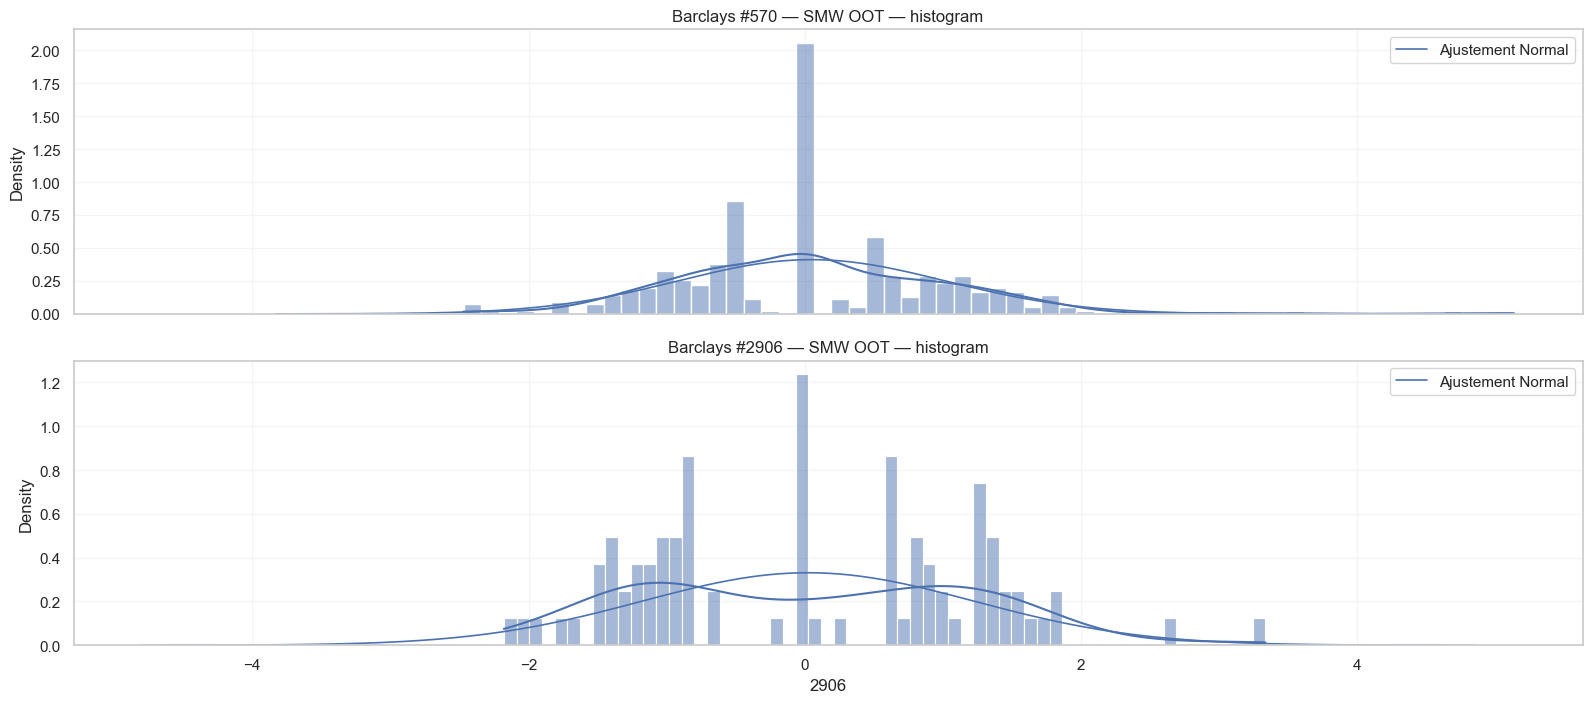

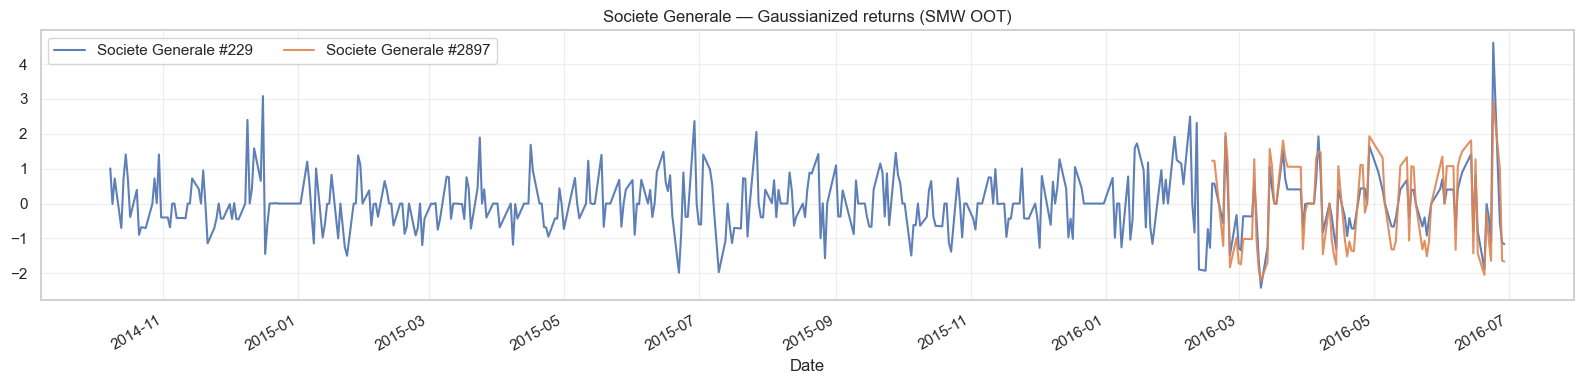

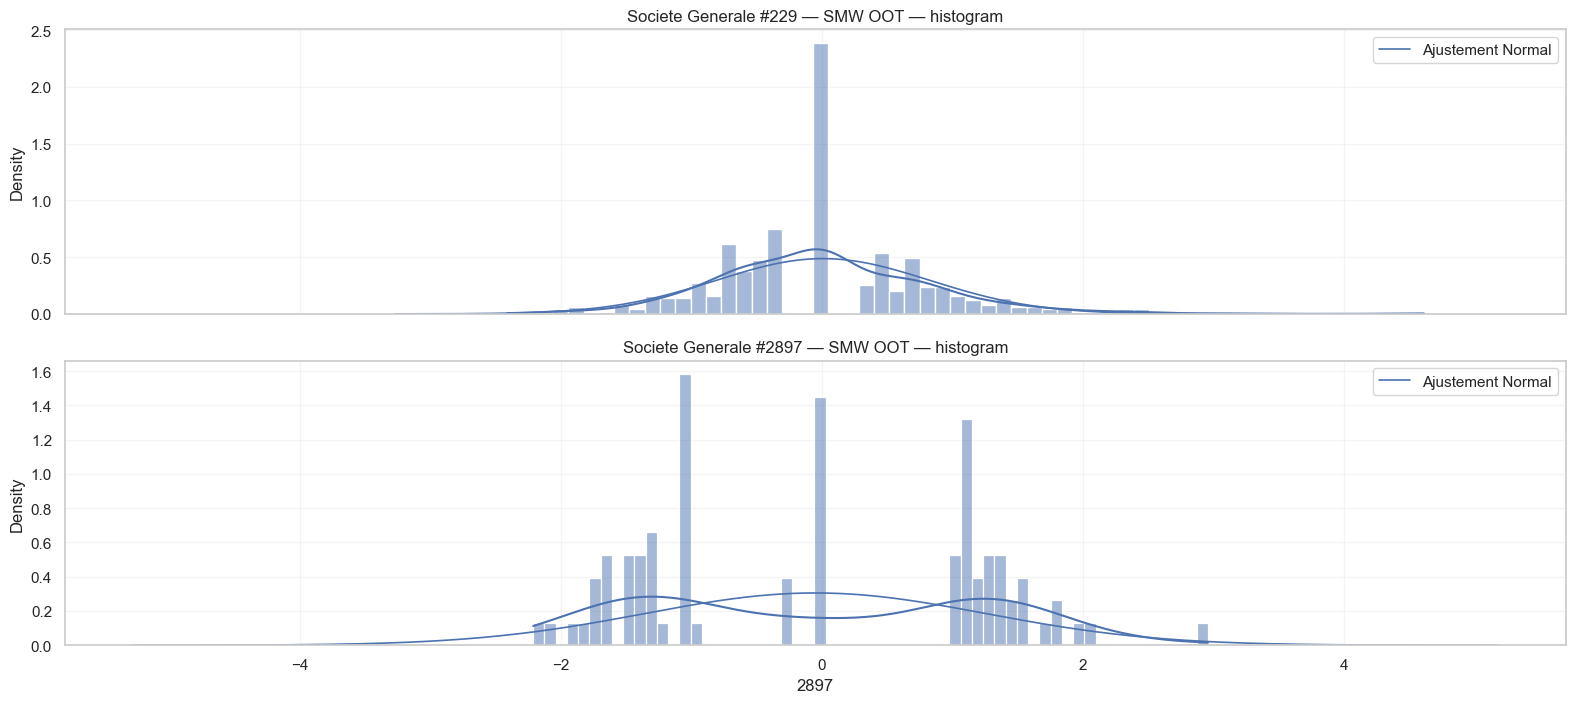

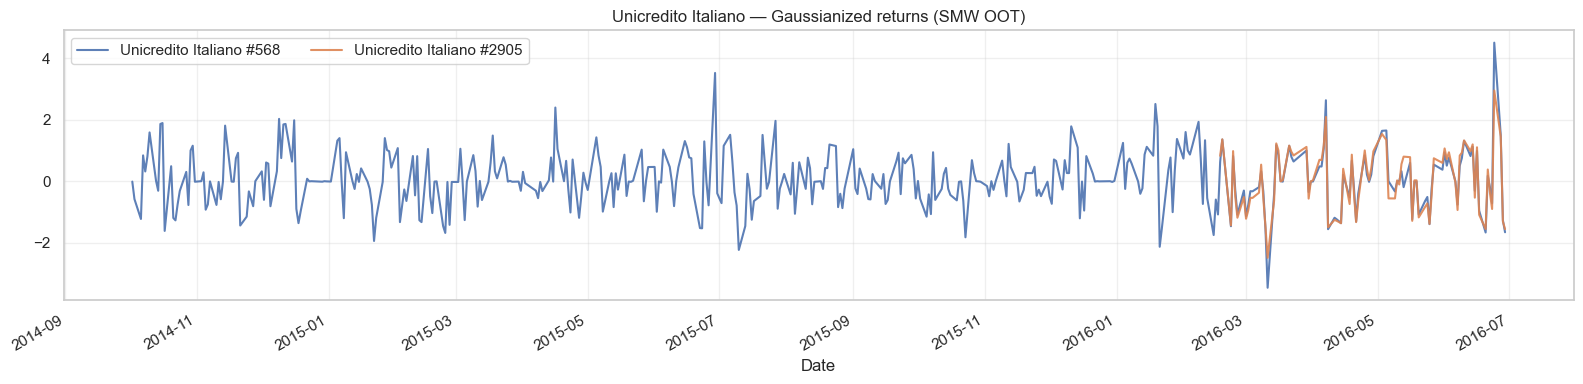

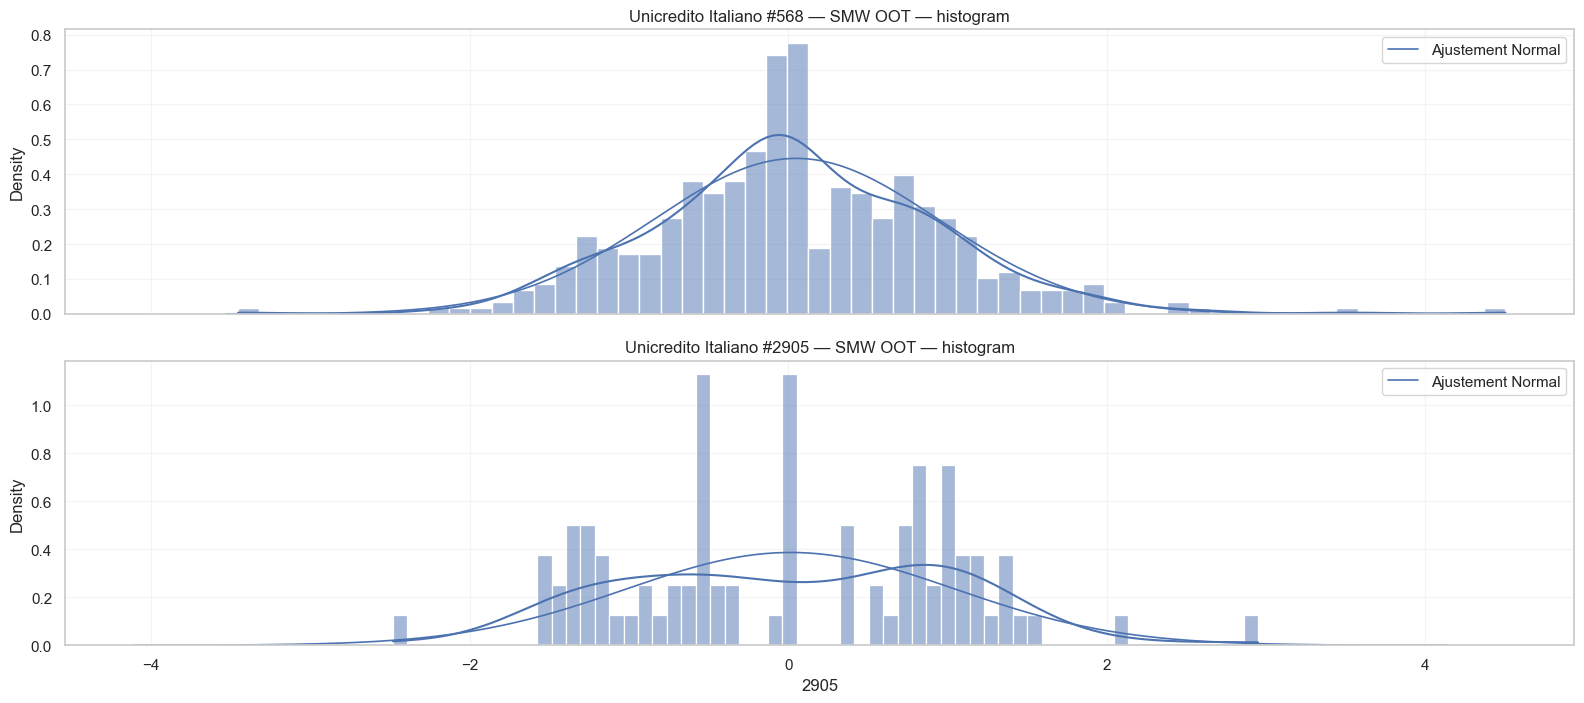

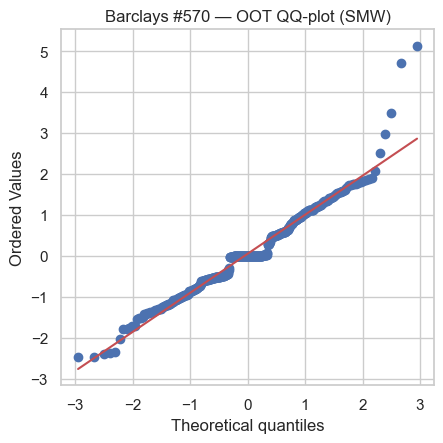

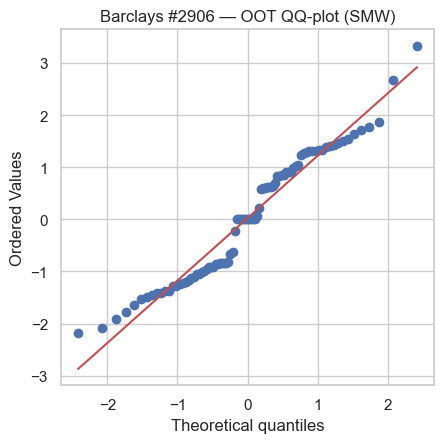

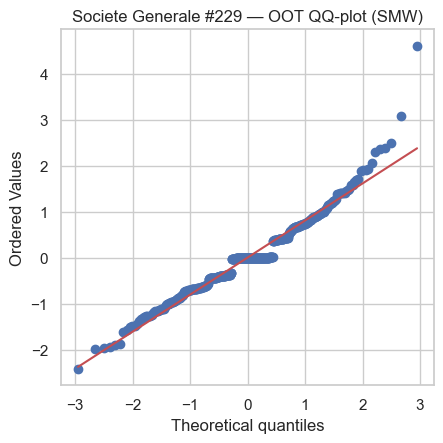

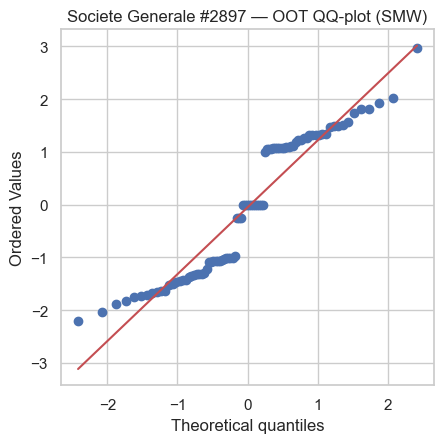

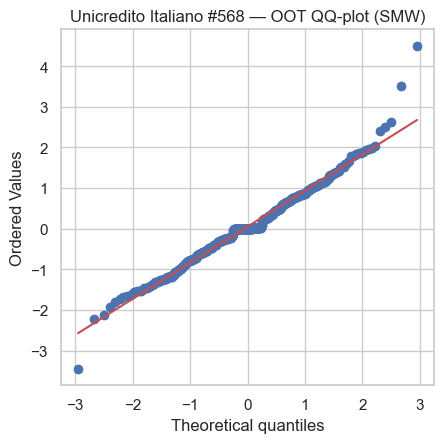

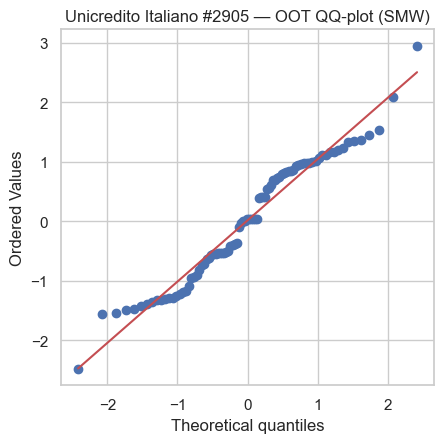

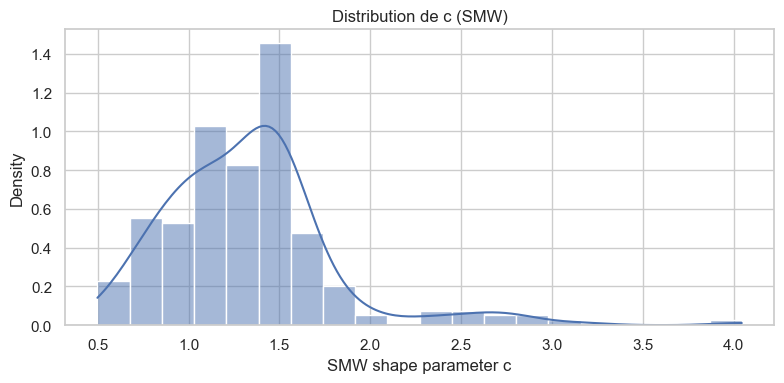

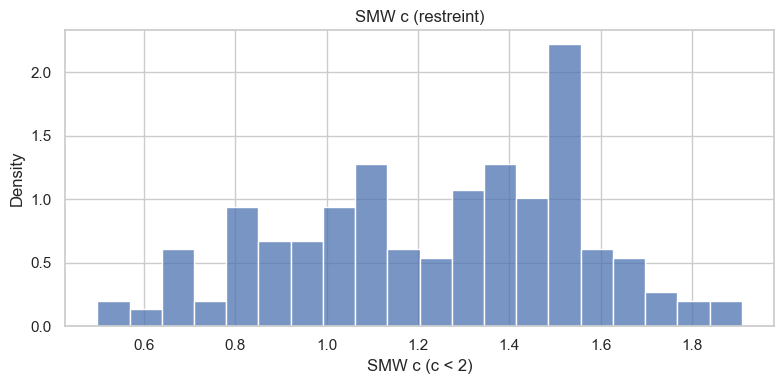

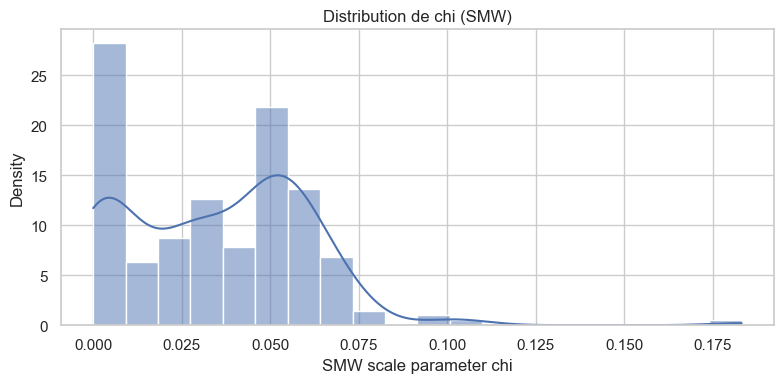

[DONE] Fichiers écrits dans : output


In [19]:
# ============================================================
# CELL 10 — Visualisations finales
# Objectif : produire les graphiques pour les noms choisis :
#            1) gaussianisation empirique (TS + histo)
#            2) gaussianisation SMW OOT (TS + histo)
#            3) QQ-plots OOT (SMW)
#            4) distributions des paramètres SMW (c, chi)
# ============================================================
# 1) Empirique
for nm in SELECTED_NAMES:
    plot_name_timeseries(nm, dc_gauss_emp, "Gaussianized returns (empirical CDF)", "empTS")
    plot_name_distributions(nm, dc_gauss_emp, "Empirical Gaussianization — histogram", "empHIST")

# 2) SMW OOT
for nm in SELECTED_NAMES:
    plot_name_timeseries(nm, gauss_oot, "Gaussianized returns (SMW OOT)", "smwOOT_TS")
    plot_name_distributions(nm, gauss_oot, "SMW OOT — histogram", "smwOOT_HIST")

# 3) QQ-plots OOT (par CDS_Id)
for nm in SELECTED_NAMES:
    ids = dc_map.get(nm, [])
    if not ids:
        continue
    for cid in ids:
        g = gauss_oot.get(cid)
        if g is None or g.dropna().empty:
            continue
        fig = plt.figure(figsize=(4.6, 4.6))
        stats.probplot(g.dropna(), dist="norm", plot=plt)
        plt.title(f"{nm} #{cid} — OOT QQ-plot (SMW)")
        plt.tight_layout()
        plt.savefig(f"{SAVE_DIR}/smwOOT_QQ_{nm}_{cid}.png", dpi=150)
        plt.show()

# 4) Paramètres SMW (c, chi) — vue d’ensemble
if smw_params:
    c_vals = np.array([p[0] for p in smw_params.values()], float)
    chi_vals = np.array([p[1] for p in smw_params.values()], float)
    c_vals = c_vals[np.isfinite(c_vals)]
    chi_vals = chi_vals[np.isfinite(chi_vals)]

    if c_vals.size:
        plt.figure(figsize=(8, 4))
        sns.histplot(c_vals, bins=20, stat="density", kde=True)
        plt.xlabel("SMW shape parameter c")
        plt.title("Distribution de c (SMW)")
        plt.tight_layout()
        plt.savefig(f"{SAVE_DIR}/smw_c_distribution.png", dpi=150)
        plt.show()

        # Option : zoom sur c < 2
        mask = c_vals < 2
        if mask.any():
            plt.figure(figsize=(8, 4))
            sns.histplot(c_vals[mask], bins=20, stat="density", kde=False)
            plt.xlabel("SMW c (c < 2)")
            plt.title("SMW c (restreint)")
            plt.tight_layout()
            plt.savefig(f"{SAVE_DIR}/smw_c_lt2.png", dpi=150)
            plt.show()

    if chi_vals.size:
        plt.figure(figsize=(8, 4))
        sns.histplot(chi_vals, bins=20, stat="density", kde=True)
        plt.xlabel("SMW scale parameter chi")
        plt.title("Distribution de chi (SMW)")
        plt.tight_layout()
        plt.savefig(f"{SAVE_DIR}/smw_chi_distribution.png", dpi=150)
        plt.show()

print(f"[DONE] Fichiers écrits dans : {SAVE_DIR}")


In [ ]:
# ============================================================
# FINAL CELL — Export interpretable summary tables (CSV)
# Objectif : produire des tables compactes (returns, Empirical z,
#            SMW OOT z, dépassements de seuils) que vous pourrez
#            me partager pour interprétation.
# ============================================================
from pathlib import Path

Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

# --- helper: id -> name (premier nom si plusieurs) ---
id_to_name = df_map.groupby("CDS_Id")["Name"].first().to_dict()

# --- helper: résumé statistique d'une série ---
def summarize_series(s: pd.Series) -> pd.Series:
    s = pd.Series(s).dropna()
    if s.empty:
        return pd.Series(dtype=float)
    return pd.Series({
        "n": int(len(s)),
        "mean": float(s.mean()),
        "std": float(s.std(ddof=1)),
        "min": float(s.min()),
        "p01": float(s.quantile(0.01)),
        "p05": float(s.quantile(0.05)),
        "p95": float(s.quantile(0.95)),
        "p99": float(s.quantile(0.99)),
        "max": float(s.max()),
        "skew": float(stats.skew(s, bias=False)),
        "excess_kurtosis": float(stats.kurtosis(s, fisher=True, bias=False)),
    })

# 1) Résumé des rendements bruts
rows = []
for cid, ser in dc_returns.items():
    summ = summarize_series(ser)
    if not summ.empty:
        summ["CDS_Id"] = cid
        summ["Name"] = id_to_name.get(cid, "")
        rows.append(summ)
returns_summary = pd.DataFrame(rows).set_index("CDS_Id").sort_index()
returns_summary.to_csv(f"{SAVE_DIR}/returns_summary.csv")

# 2) Gaussianisation empirique (tests & dépassements)
rows = []
for cid, g in dc_gauss_emp.items():
    s = pd.Series(g).dropna()
    if s.empty:
        continue
    ks = stats.kstest(s, "norm")                 # vs N(0,1)
    jb = stats.jarque_bera(s)
    rows.append({
        "CDS_Id": cid,
        "Name": id_to_name.get(cid, ""),
        "n": int(len(s)),
        "mean_z": float(s.mean()),
        "std_z": float(s.std(ddof=1)),
        "skew_z": float(stats.skew(s, bias=False)),
        "excess_kurtosis_z": float(stats.kurtosis(s, fisher=True, bias=False)),
        "KS_stat": float(ks.statistic), "KS_p": float(ks.pvalue),
        "JB_stat": float(jb.statistic), "JB_p": float(jb.pvalue),
        "exceed_abs_z_gt_2": float((np.abs(s) > 2).mean()),
        "exceed_abs_z_gt_3": float((np.abs(s) > 3).mean()),
    })
gauss_emp_summary = pd.DataFrame(rows).set_index("CDS_Id").sort_index()
gauss_emp_summary.to_csv(f"{SAVE_DIR}/gaussian_empirical_summary.csv")

# 3) SMW OOT (tests & dépassements)
rows = []
for cid, g in gauss_oot.items():
    s = pd.Series(g).dropna()
    if s.empty:
        continue
    ks = stats.kstest(s, "norm")                 # vs N(0,1)
    jb = stats.jarque_bera(s)
    rows.append({
        "CDS_Id": cid,
        "Name": id_to_name.get(cid, ""),
        "n": int(len(s)),
        "mean_z": float(s.mean()),
        "std_z": float(s.std(ddof=1)),
        "skew_z": float(stats.skew(s, bias=False)),
        "excess_kurtosis_z": float(stats.kurtosis(s, fisher=True, bias=False)),
        "KS_stat": float(ks.statistic), "KS_p": float(ks.pvalue),
        "JB_stat": float(jb.statistic), "JB_p": float(jb.pvalue),
        "exceed_abs_z_gt_2": float((np.abs(s) > 2).mean()),
        "exceed_abs_z_gt_3": float((np.abs(s) > 3).mean()),
    })
gauss_smw_oot_summary = pd.DataFrame(rows).set_index("CDS_Id").sort_index()

# Joindre les tailles Train/OOT et (c,chi) si disponibles
diag_df = pd.DataFrame(diag).T if len(diag) else pd.DataFrame()
if not diag_df.empty:
    diag_df = diag_df.rename_axis("CDS_Id").reset_index()
    gauss_smw_oot_summary = gauss_smw_oot_summary.reset_index().merge(
        diag_df[["CDS_Id","c","chi","n_train","n_oot","KS_stat","KS_p"]],
        on="CDS_Id", how="left", suffixes=("", "_diag")
    ).set_index("CDS_Id")

gauss_smw_oot_summary.to_csv(f"{SAVE_DIR}/gaussian_smw_oot_summary.csv")

# 4) Table des dépassements (comparatif Empirique vs SMW OOT)
def exceed_table(d: dict, label: str):
    rows = []
    for cid, g in d.items():
        s = pd.Series(g).dropna()
        if s.empty: continue
        rows.append({
            "CDS_Id": cid, "Name": id_to_name.get(cid, ""),
            f"{label}_n": int(len(s)),
            f"{label}_exceed_abs_z_gt_2": float((np.abs(s) > 2).mean()),
            f"{label}_exceed_abs_z_gt_3": float((np.abs(s) > 3).mean()),
        })
    return pd.DataFrame(rows)

ex_emp = exceed_table(dc_gauss_emp, "emp")
ex_oot = exceed_table(gauss_oot, "smw_oot")
exceed_compare = (ex_emp.merge(ex_oot, on=["CDS_Id","Name"], how="outer")
                       .set_index("CDS_Id").sort_index())
exceed_compare.to_csv(f"{SAVE_DIR}/exceedance_compare.csv")

print("[Exported]")
print(" - returns_summary.csv")
print(" - gaussian_empirical_summary.csv")
print(" - gaussian_smw_oot_summary.csv")
print(" - exceedance_compare.csv")

[Exported]
 - returns_summary.csv
 - gaussian_empirical_summary.csv
 - gaussian_smw_oot_summary.csv
 - exceedance_compare.csv
